In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [7]:
def find_feature_matches(img1, img2):
    orb= cv2.ORB_create()

    keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(img2, None)
    print(keypoints1)

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)
    
    min_dist, max_dist = float('inf'), float('-inf')
    for m in matches:
        dist = m.distance
        if dist > max_dist:
            max_dist = dist
        if dist < min_dist:
            min_dist = dist
    print(f'max_dist: {max_dist}')
    print(f'min_dist: {min_dist}')
    
    good_matches = []
    for m in matches:
        if m.distance <= max(2 * min_dist, 30.0):
            good_matches.append(m)
            
    print(f'good_matches: {len(good_matches)}')
            
     
    img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.imshow(img_matches)
    plt.show()

    return keypoints1, keypoints2, good_matches


In [8]:
def pixel2cam(p, K):
    p = np.append(p, 1)
    return np.linalg.inv(K) @ p

In [9]:
def pose_estimation_2d2d(keypoints1, keypoints2, matches, K):
    points1 = np.float32([keypoints1[m.queryIdx].pt for m in matches])
    points2 = np.float32([keypoints2[m.trainIdx].pt for m in matches])

    E, mask = cv2.findEssentialMat(points1, points2, K, method=cv2.RANSAC) 
    
    _, R, t, mask = cv2.recoverPose(E, points1, points2, K)

    return R, t


In [10]:
def triangulation(keypoints1, keypoints2, good_matches, K, R, t):
    T1 = np.array([[1, 0, 0, 0],
                   [0, 1, 0, 0],
                   [0, 0, 1, 0]])
    T2 = np.hstack((R, t))
    
    print(T2)
    
    points1 = np.float64([pixel2cam(keypoints1[m.queryIdx].pt, K) for m in good_matches])
    points2 = np.float64([pixel2cam(keypoints2[m.trainIdx].pt, K) for m in good_matches])
    
    points4d = cv2.triangulatePoints(T1, T2, points1[:, :2].T, points2[:, :2].T)
    points3d = points4d[:3] / points4d[3]
    
    
    return points3d.T
    

(< cv2.KeyPoint 0x7f29c2468e70>, < cv2.KeyPoint 0x7f29c2468e10>, < cv2.KeyPoint 0x7f29c2468d80>, < cv2.KeyPoint 0x7f29c2468de0>, < cv2.KeyPoint 0x7f29c2468db0>, < cv2.KeyPoint 0x7f29c2468ea0>, < cv2.KeyPoint 0x7f29c2468ed0>, < cv2.KeyPoint 0x7f29c2468f00>, < cv2.KeyPoint 0x7f29c2468f30>, < cv2.KeyPoint 0x7f29c2468f60>, < cv2.KeyPoint 0x7f29c2468f90>, < cv2.KeyPoint 0x7f29c2468fc0>, < cv2.KeyPoint 0x7f29c2453030>, < cv2.KeyPoint 0x7f29c2453060>, < cv2.KeyPoint 0x7f29c2453090>, < cv2.KeyPoint 0x7f29c24530c0>, < cv2.KeyPoint 0x7f29c24530f0>, < cv2.KeyPoint 0x7f29c2453120>, < cv2.KeyPoint 0x7f29c2453150>, < cv2.KeyPoint 0x7f29c24531b0>, < cv2.KeyPoint 0x7f29c24531e0>, < cv2.KeyPoint 0x7f29c2453210>, < cv2.KeyPoint 0x7f29c2453240>, < cv2.KeyPoint 0x7f29c2453270>, < cv2.KeyPoint 0x7f29c24532a0>, < cv2.KeyPoint 0x7f29c24532d0>, < cv2.KeyPoint 0x7f29c2453300>, < cv2.KeyPoint 0x7f29c2453330>, < cv2.KeyPoint 0x7f29c2453360>, < cv2.KeyPoint 0x7f29c2453390>, < cv2.KeyPoint 0x7f29c24533c0>, < cv2.K

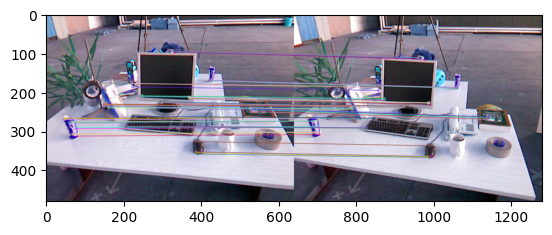

R: [[ 0.99740889 -0.05350816  0.04808731]
 [ 0.05145842  0.99775337  0.04289815]
 [-0.05027468 -0.0403125   0.99792152]]
t: [[-0.96488307]
 [-0.21318668]
 [ 0.15346695]]
[[ 0.99740889 -0.05350816  0.04808731 -0.96488307]
 [ 0.05145842  0.99775337  0.04289815 -0.21318668]
 [-0.05027468 -0.0403125   0.99792152  0.15346695]]
[[-2.62777276e+00  3.02396279e-01  5.71295854e+00]
 [ 1.63620170e-01  1.37061885e+00 -7.28484739e+00]
 [-1.09595505e+01 -4.09985770e+00  2.75526822e+01]
 [-2.85604283e+00  8.60740911e-01  6.82418412e+00]
 [-6.78237561e-02  2.87615630e-01 -3.82152840e+00]
 [ 2.27820686e+00  6.05539577e+00 -1.88557401e+01]
 [-3.14778313e+00  6.02730521e-01  7.20350690e+00]
 [-2.07038170e+02 -9.17446326e+01  1.47572925e+03]
 [-2.97797773e+00  7.82749735e-01  7.00514548e+00]
 [-1.15292146e-01  2.68113969e-01 -3.74641721e+00]
 [-2.70479162e+00  2.69567783e-01  5.87150055e+00]
 [-5.37662695e+01 -2.06568591e+01  2.32489873e+02]
 [ 3.24952499e-01  1.02840015e+00 -5.24528177e+00]
 [ 2.29658410

In [11]:
img1 = cv2.imread('../../images/1.png')
img2 = cv2.imread('../../images/2.png')

K = np.array([[520.9, 0, 325.1],
                  [0, 521.0, 249.7],
                  [0, 0, 1]], dtype = np.float64)

keypoints1, keypoints2, good_matches = find_feature_matches(img1, img2)
R, t = pose_estimation_2d2d(keypoints1, keypoints2, good_matches, K)

t_x = np.array([
    [0, -t[2, 0], t[1, 0]],
    [t[2, 0], 0, -t[0, 0]],
    [-t[1, 0], t[0, 0], 0]
])

print(f'R: {R}')
print(f't: {t}')

for m in good_matches:
    pt1 = pixel2cam(keypoints1[m.queryIdx].pt, K)
    y1 = np.array([[pt1[0]], [pt1[1]], [1]])
    pt2 = pixel2cam(keypoints2[m.trainIdx].pt, K)
    y2 = np.array([[pt2[0]], [pt2[1]], [1]])
    d = y2.T @ t_x @ R @ y1
    # print(f'match m: {d}')

points3d = triangulation(keypoints1, keypoints2, good_matches, K, R, t)

print(points3d)
